# Import 'files' module to enable file upload/download in Google Colab.


In [1]:
from google.colab import files

# Read the training, testing, and submission files into tables for data analysis.


In [2]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv("sample_submission.csv")

# Check dataset size, summary info, statistics, and preview first rows of train data.


In [3]:
print(train.shape)
print(test.shape)
train.info()
train.describe()
train.head()

(20000, 17)
(12000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


# Plot the distribution of the 'efficiency' column with a histogram and density curve.


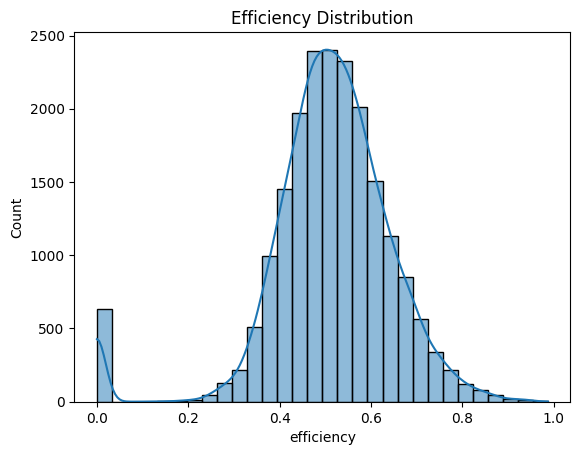

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.histplot(train['efficiency'], kde=True, bins=30)
plt.title("Efficiency Distribution")
plt.show()

# Select numerical columns (excluding 'id'), compute their correlation, and visualize it as a heatmap.


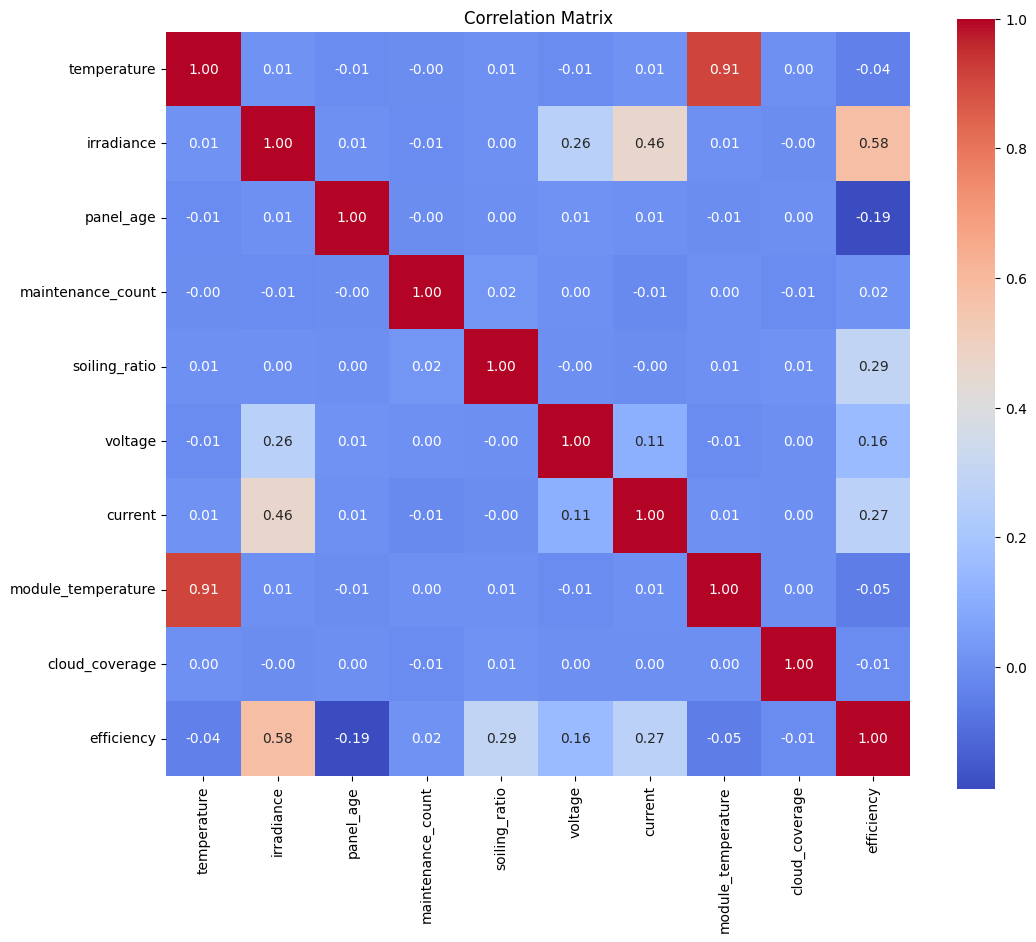

In [5]:
numerical_features = train.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns

plt.figure(figsize=(12, 10))
corr = train[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()


# Convert specified columns in train and test data to numeric types, handling errors by setting invalid values to NaN.


In [6]:
# Force all numeric columns to proper dtype
numeric_cols = [
    'temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count',
    'soiling_ratio', 'voltage', 'current', 'module_temperature',
    'cloud_coverage', 'wind_speed', 'pressure'
]

for col in numeric_cols:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')


# Creating new features by combining and transforming existing data to improve model performance.


In [7]:
def feature_engineering(df):
    df['power_output'] = df['voltage'] * df['current']
    df['temp_diff'] = df['module_temperature'] - df['temperature']
    df['cleanliness_effect'] = (1 - df['soiling_ratio']) * df['irradiance']
    df['panel_degradation'] = df['panel_age'] * df['soiling_ratio']
    df['irradiance_per_cloud'] = df['irradiance'] / (df['cloud_coverage'] + 1)
    df['cooling_factor'] = df['wind_speed'] / (df['module_temperature'] + 1)

    # Selectively added useful ones — these were included and helped
    df['stress_index'] = df['temp_diff'] / (df['wind_speed'] + 1)
    df['soiling_humidity'] = df['soiling_ratio'] * df['humidity']
    df['maintenance_effect'] = df['maintenance_count'] / (df['panel_age'] + 1)
    df['instability_index'] = df['wind_speed'] / (df['pressure'] + 1)
    return df


train = feature_engineering(train)
test = feature_engineering(test)


# Import libraries for splitting data, encoding labels, and evaluating model performance using mean squared error.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Split the training data into training and validation sets to evaluate the model later.


In [9]:
# Split for validation
X = train.drop(columns=['id', 'efficiency'])
y = train['efficiency']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert categorical columns to numbers using Label Encoding for both train and test data.


In [10]:
# Encode categorical columns
cat_cols = ['string_id', 'error_code', 'installation_type']
label_encoders = {}

for col in cat_cols:
    # Convert to string type before encoding
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    # Use the same fitted encoder for the test set
    test[col] = le.transform(test[col])
    label_encoders[col] = le


# Perform basic feature engineering and label encoding, then select relevant features for modeling.


In [11]:


#  Feature Engineering
def basic_fe(df):
    df['power_output'] = df['voltage'] * df['current']
    df['temp_diff'] = df['module_temperature'] - df['temperature']
    df['cleanliness_effect'] = (1.0 - df['soiling_ratio']) * df['irradiance']
    df['panel_degradation'] = df['panel_age'] * df['soiling_ratio']
    return df

train_df = basic_fe(train.copy())
test_df = basic_fe(test.copy())

# Label encode
cat_cols = ['string_id', 'error_code', 'installation_type']
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Features
features = [
    'irradiance', 'soiling_ratio', 'current', 'voltage',
    'power_output', 'temp_diff', 'cleanliness_effect', 'panel_degradation',
    'temperature', 'module_temperature',
    'humidity', 'panel_age', 'maintenance_count',
    'string_id', 'error_code', 'installation_type'
]
X = train_df[features]
y = train_df['efficiency']
X_test = test_df[features]




# Train CatBoost and LightGBM models using 5-fold CV, combine predictions with Ridge regression stacking, and save final results.


# Using both CatBoost and LightGBM leverages their different strengths and helps improve prediction accuracy by combining them.


In [13]:
!pip install catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from google.colab import files

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_cat = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
test_preds_cat = []
test_preds_lgb = []

X_val = X_val[features]    # features is your list of column names
X_test_ordered = X_test[features]

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    cat_model = CatBoostRegressor(
        iterations=450, depth=5, learning_rate=0.025534640009695183,
        l2_leaf_reg=0.06526452722129178, loss_function='RMSE',
        random_seed=42, verbose=0
    )
    lgb_model = lgb.LGBMRegressor(
        n_estimators=581, learning_rate=0.01679005991903982,
        max_depth=4, num_leaves=8, reg_alpha=0.8753590700706911,
        reg_lambda=0.0001327729601568529, random_state=42, early_stopping_rounds=50, verbose=0
    )

    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    oof_cat[val_idx] = cat_model.predict(X_val)
    oof_lgb[val_idx] = lgb_model.predict(X_val)

    test_preds_cat.append(cat_model.predict(X_test))
    test_preds_lgb.append(lgb_model.predict(X_test))

# Prepare meta features
meta_features = np.vstack([oof_cat, oof_lgb]).T
meta_test = np.vstack([np.mean(test_preds_cat, axis=0), np.mean(test_preds_lgb, axis=0)]).T

# Train meta model
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_features, y)

# Predict and clip
final_preds = np.clip(meta_model.predict(meta_test), 0, 1)

pd.DataFrame({'id': test_df['id'], 'efficiency': final_preds}).to_csv("stacking_meta_submission.csv", index=False)
files.download("stacking_meta_submission.csv")


[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] early_stopping_round is set=50, early_sto

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>